# Проект 4

# Импорт библиотек

In [1]:
import pandas as pd
#import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_validate
#from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

#pd.options.mode.chained_assignment = None

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# 1.  Данные

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [3]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [4]:
df[df['Train']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 73799 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  i

In [5]:
df[df['Train']==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Итак, в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Признаков всего 20(в общем датасете с добавленной меткой Train), из них 1 - временной ряд, 6 бинарных, 7 категориальных и 8 числовых. Пропуски есть только в столбе education. client_id - идентификатор, который не влияет на целевую переменную.
Описания полей датасета:

    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту

In [6]:
# внесем данные из резюме в списки 
# временной ряд 
time_cols = ['app_date']
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные 
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# client_id не включаем в списки

# 2.  EDA

Создадим функции для быстрого обзора признаков.

In [7]:
#общая информация
k = 1.5
def view(col,data):
    print('Кол-во строк:', len(data[str(col)]))
    print('Кол-во Nan:', data[str(col)].isna().sum())
    print('//////без логарифма///////')
    IQR = data[str(col)].quantile(0.75) - data[str(col)].quantile(0.25)
    perc25 = data[str(col)].quantile(0.25)
    perc75 = data[str(col)].quantile(0.75)
    print('Среднее:', data[str(col)].mean(), '\nМедиана:', data[str(col)].median(), '\nMin:',data[str(col)].min(), '\nMax:', data[str(col)].max())
    print("Границы выбросов: [{f}, {l}].".format(f=perc25 - k*IQR, l=perc75 + k*IQR))
    # Проверить!!!!!!
    print('Кол-во выбросов:', len(data[data[str(col)]<perc25 - k*IQR]) + len(data[data[str(col)]>perc75 + k*IQR]))
    if sum(data[col]<0) == 0:
        print('//////если взять логарифм///////')
        df = data[col].apply(lambda x: x+1).apply(log)
        IQR = df.quantile(0.75) - df.quantile(0.25)
        perc25 = df.quantile(0.25)
        perc75 = df.quantile(0.75)
        print('Среднее:', df.mean(), '\nМедиана:', df.median(), '\nMin:',df.min(), '\nMax:', df.max())
        print("Границы выбросов: [{f}, {l}].".format(f=perc25 - k*IQR, l=perc75 + k*IQR))
        print('Кол-во выбросов:', sum(df<(perc25 - k*IQR)) + sum(df>(perc75 + k*IQR)))
    return None

In [8]:
#график
def plot_with_log(col,data):
    fig,axes = plt.subplots(2, 2, figsize = (15,10))
    axes[0][0].hist(data[col])
    axes[0][0].set_title('гистограмма празнака')
    sns.boxplot(y=col, data=data, ax = axes[0][1])
    axes[0][1].set_title('boxplot признака')
    axes[1][0].hist(data[col].apply(lambda x: x+1).apply(log))
    axes[1][0].set_title('гистограмма логарифмированного празнака')
    sns.boxplot(y=data[col].apply(lambda x: x+1).apply(log), ax = axes[1][1])
    axes[1][1].set_title('boxplot логарифмированного признака')

## 1.num_cols

1.1 age

In [9]:
view('age', df[df.Train==1])

Кол-во строк: 73799
Кол-во Nan: 0
//////без логарифма///////
Среднее: 39.280640659087524 
Медиана: 37.0 
Min: 21 
Max: 72
Границы выбросов: [3.0, 75.0].
Кол-во выбросов: 0
//////если взять логарифм///////
Среднее: 3.655331671375122 
Медиана: 3.6375861597263857 
Min: 3.091042453358316 
Max: 4.290459441148391
Границы выбросов: [2.7472375640469258, 4.5785699385488465].
Кол-во выбросов: 0


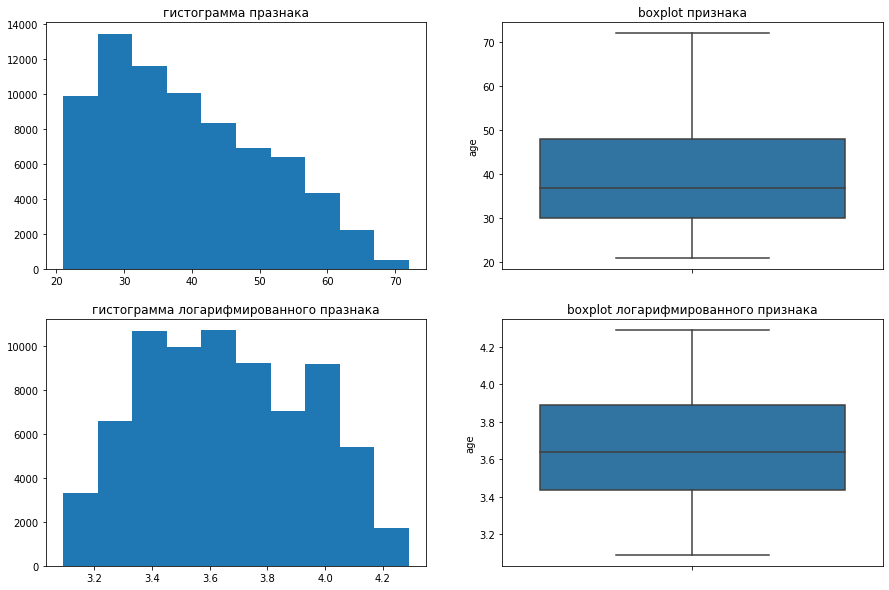

In [10]:
plot_with_log('age', df[df.Train==1])

Распределение скорее логнормальное, выбросов нет. Возьмем логарифм от признака

In [11]:
df['age'] = np.log(df['age'] + 1)

1.2 decline_app_cnt 

In [12]:
view('decline_app_cnt', df[df.Train==1])

Кол-во строк: 73799
Кол-во Nan: 0
//////без логарифма///////
Среднее: 0.2757489938888061 
Медиана: 0.0 
Min: 0 
Max: 33
Границы выбросов: [0.0, 0.0].
Кол-во выбросов: 12585
//////если взять логарифм///////
Среднее: 0.15245102815900716 
Медиана: 0.0 
Min: 0.0 
Max: 3.5263605246161616
Границы выбросов: [0.0, 0.0].
Кол-во выбросов: 12585


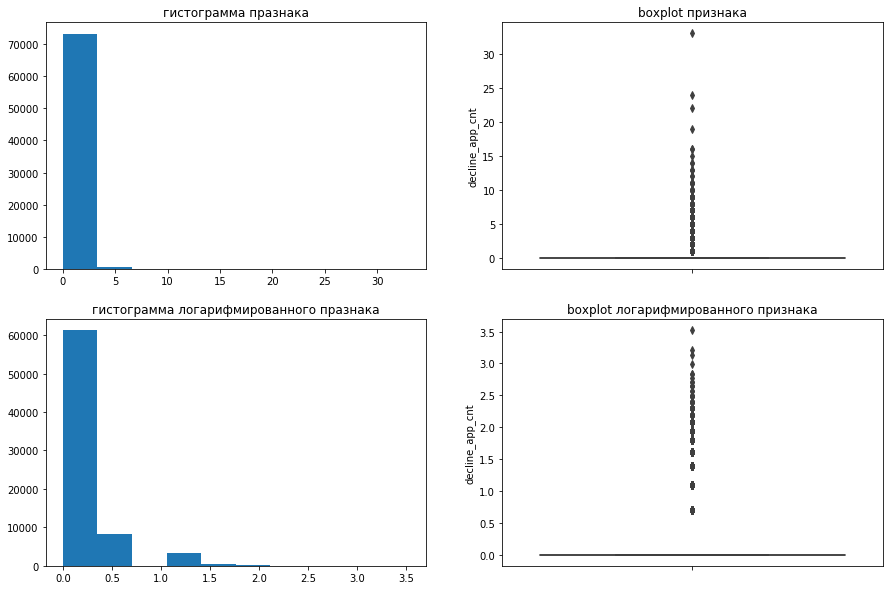

In [13]:
plot_with_log('decline_app_cnt', df[df.Train==1])

In [14]:
tr_df = df[df.Train==1]
len(tr_df[tr_df['decline_app_cnt']>10])

23

In [15]:
len(tr_df[tr_df['decline_app_cnt']>2])

1720

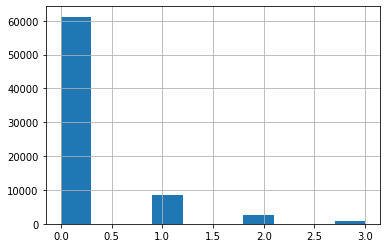

In [16]:
tr_df[tr_df['decline_app_cnt']<4]['decline_app_cnt'].hist()

Выборосов, если считать по IQR, очень много. Очень большая часть значений лежит в (0,4). Оставим пока признак как есть.

1.3 bki_request_cnt

In [17]:
view('bki_request_cnt', df[df.Train==1])

Кол-во строк: 73799
Кол-во Nan: 0
//////без логарифма///////
Среднее: 2.0003387579777505 
Медиана: 1.0 
Min: 0 
Max: 53
Границы выбросов: [-4.5, 7.5].
Кол-во выбросов: 1755
//////если взять логарифм///////
Среднее: 0.8780139042374759 
Медиана: 0.6931471805599453 
Min: 0.0 
Max: 3.9889840465642745
Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Кол-во выбросов: 9


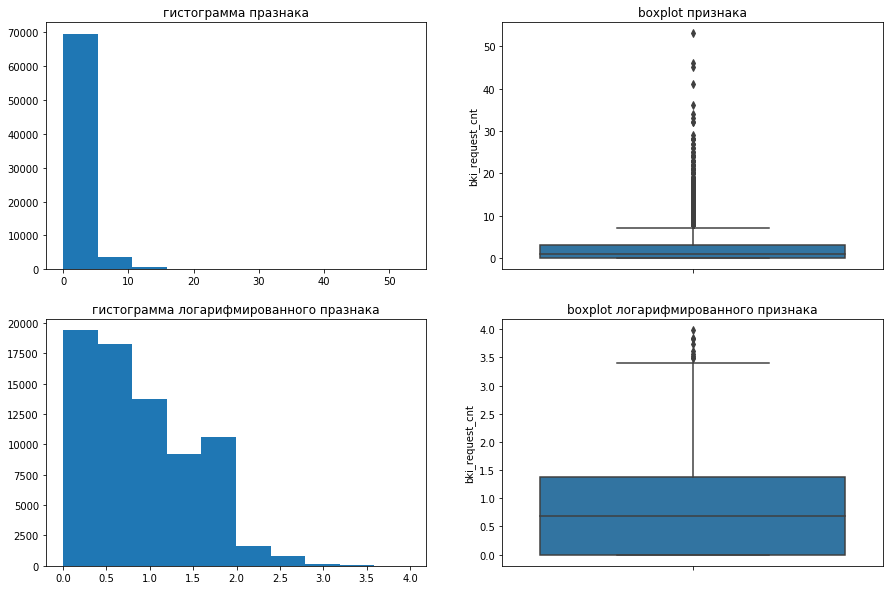

In [18]:
plot_with_log('bki_request_cnt', df[df.Train==1])

Если взять логарифм, то максимальное значение близко к правой границе выбросов. Распределение логнормальное.

In [19]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

1.4 income

In [20]:
view('income', df[df.Train==1])

Кол-во строк: 73799
Кол-во Nan: 0
//////без логарифма///////
Среднее: 41099.77541701107 
Медиана: 30000.0 
Min: 1000 
Max: 1000000
Границы выбросов: [-22000.0, 90000.0].
Кол-во выбросов: 4695
//////если взять логарифм///////
Среднее: 10.345885575691275 
Медиана: 10.308985993422082 
Min: 6.90875477931522 
Max: 13.815511557963774
Границы выбросов: [8.590378193705899, 12.092136480586621].
Кол-во выбросов: 1767


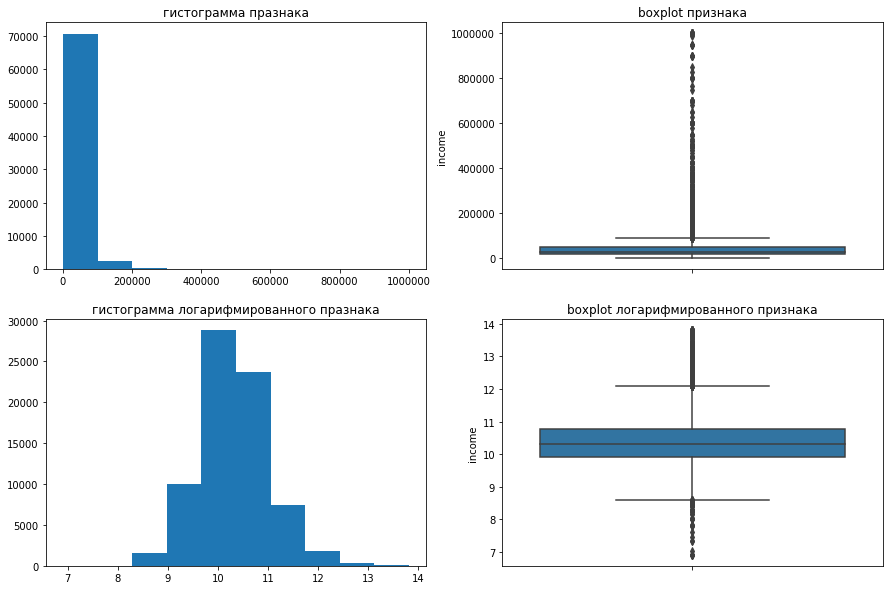

In [21]:
plot_with_log('income', df[df.Train==1])

Распределение логнормальное. Выбросов много даже после логарифмирования. Оставим пока там, по необходимости потом вернемся.

In [22]:
df['income'] = np.log(df['income'] + 1)

1.5 score_bki

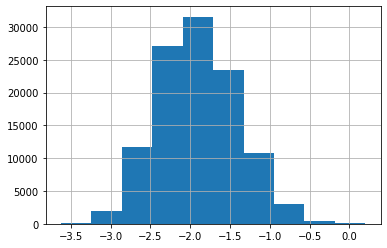

In [23]:
df.score_bki.hist()

In [24]:
view('score_bki', df[df.Train==1])

Кол-во строк: 73799
Кол-во Nan: 0
//////без логарифма///////
Среднее: -1.9047236272216417 
Медиана: -1.92082293 
Min: -3.62458632 
Max: 0.19977285
Границы выбросов: [-3.2940876975, -0.5352773974999998].
Кол-во выбросов: 351


Рапрседеление нормальное. Выбросов не много.

## 2.cat_cols

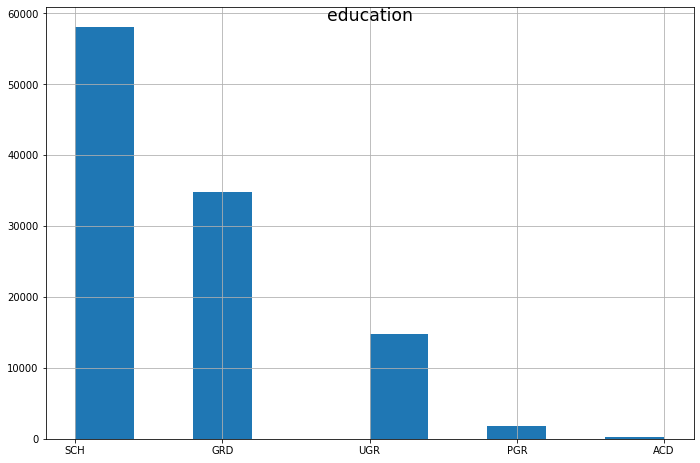

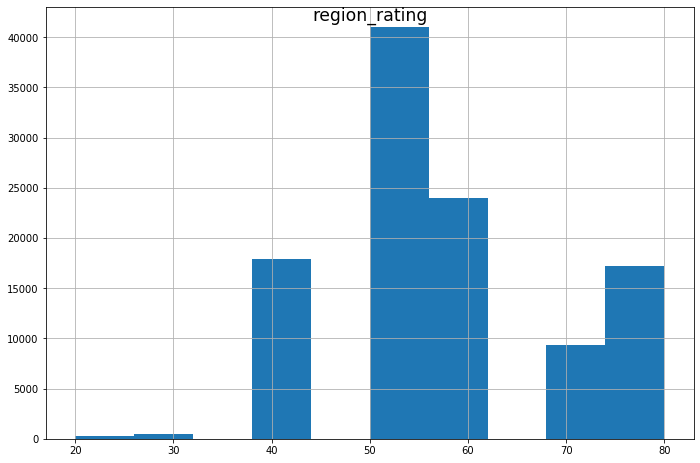

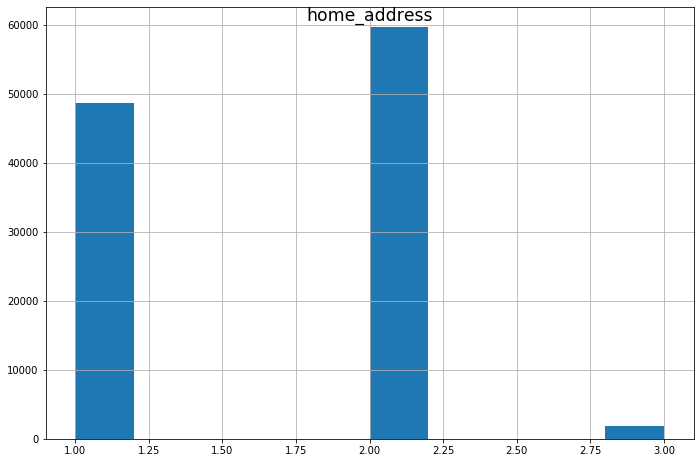

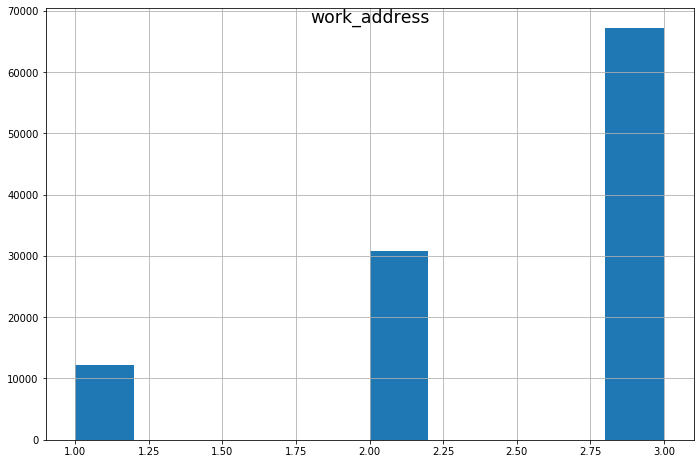

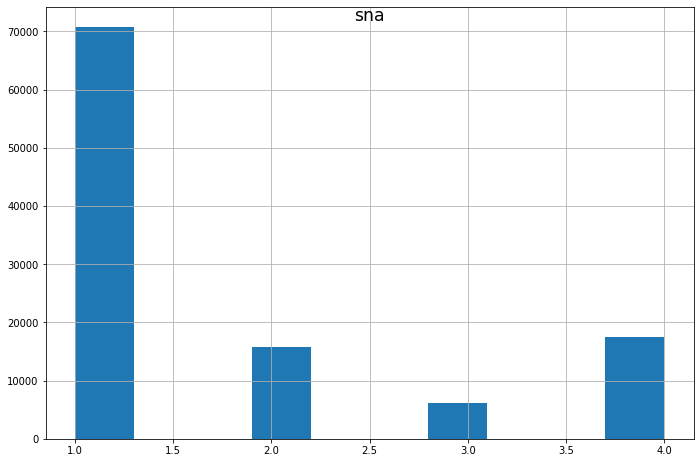

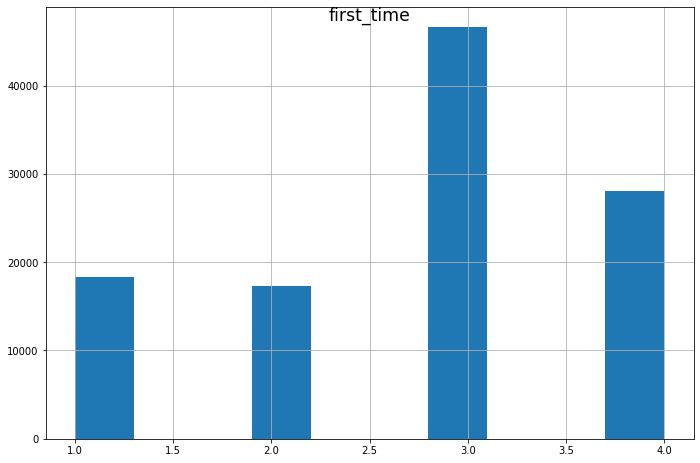

In [25]:
for column in cat_cols:
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1.5, 1.5])
    df[column].hist(ax=axes)
    plt.suptitle(column, fontsize='xx-large',x=0.75, y=1.5)

Из общего обзора помним, что для признака education:
1) есть пропуски
2) значения не числовые

In [26]:
sum(df.education.isna())

478

In [27]:
#заполняем пропуски модой
df['education'] = df['education'].fillna('SCH')

In [28]:
# Преобразуем education в целочисленный формат
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df.education.unique()

array([3, 1, 4, 2, 0])

## 3.bin_cols

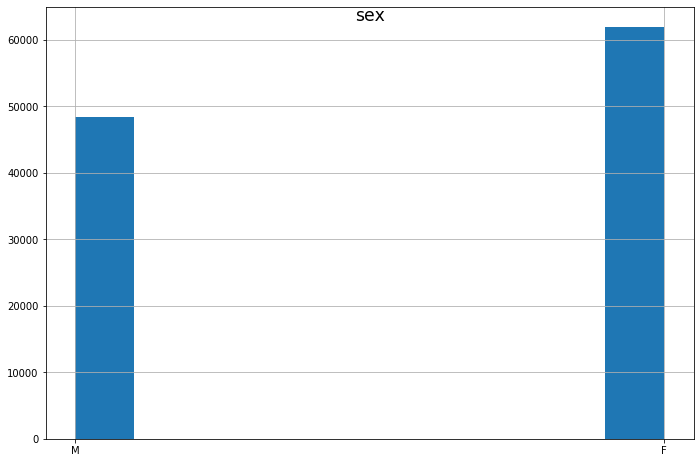

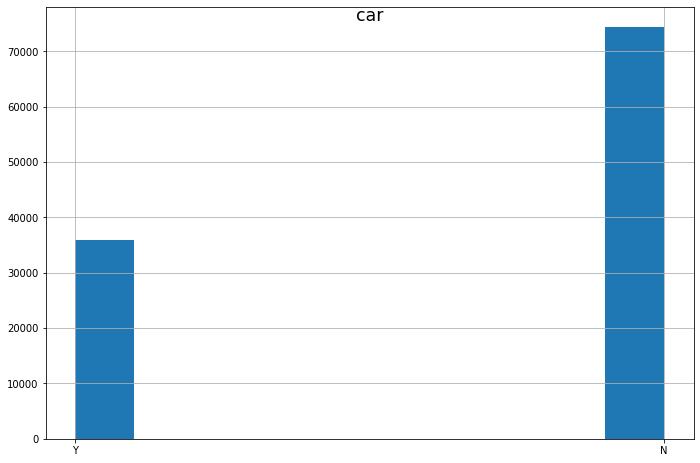

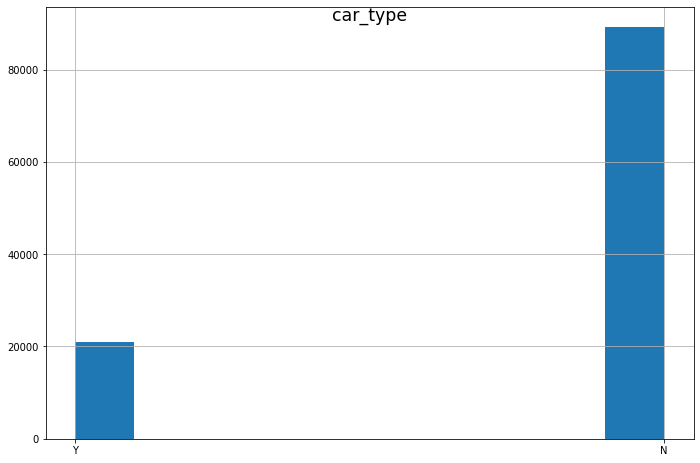

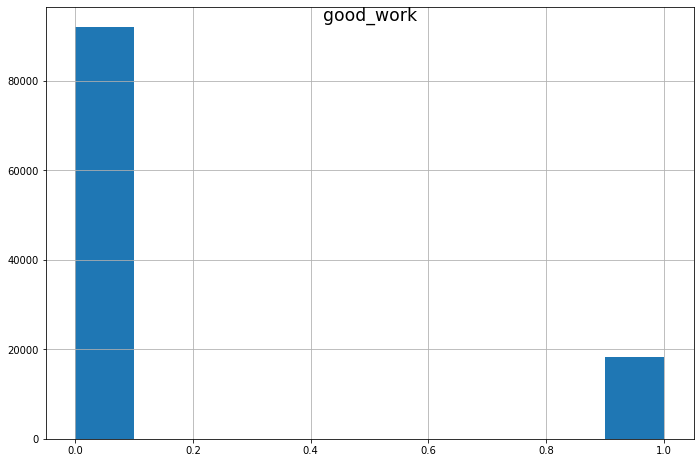

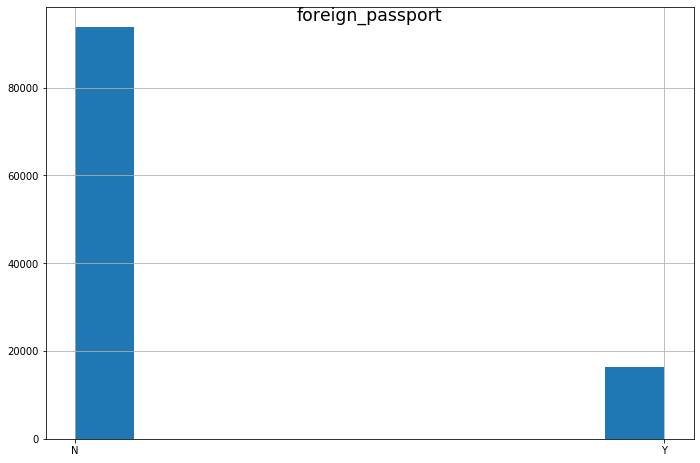

In [29]:
for column in bin_cols:
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1.5, 1.5])
    df[column].hist(ax=axes)
    plt.suptitle(column, fontsize='xx-large',x=0.75, y=1.5)

In [30]:
# Преобразуем бинарные признаки с помощью LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

## app_date - числовой ряд

In [31]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [32]:
# начало и конец периода
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Заявки пдавались только в первые 4 месяца 2014 года. Причем в первый месяц заяков подано немного больше, чем в остальные

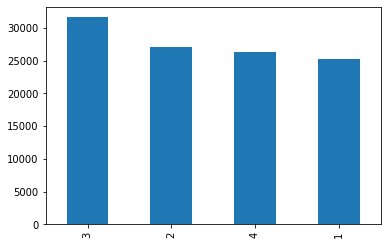

In [33]:
df['app_date'].dt.month.value_counts().plot.bar()

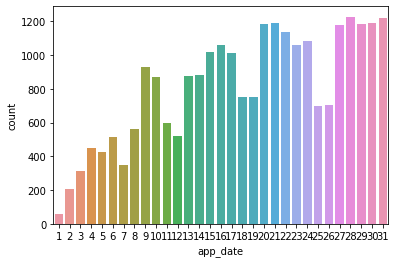

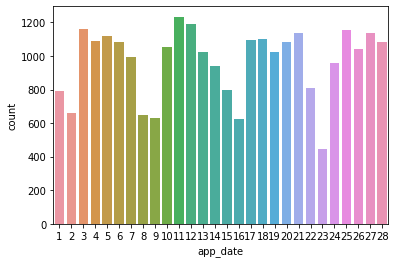

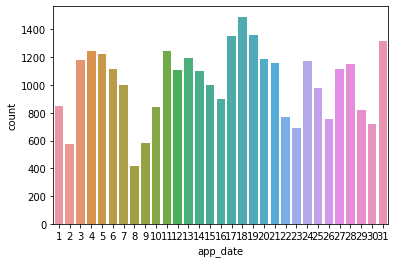

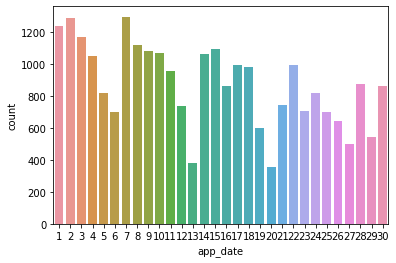

In [34]:
df['month'] = df['app_date'].dt.month
for i in [1,2,3,4]:
    plt.figure()
    sns.countplot(x=df[df.month == i]['app_date'].dt.day, data=df[df.month == i])
    plt.show()

распределение по дням более-менее равномерное, перескоков нет

In [35]:
# Вводим новый признак - номер дня с даты первой заявки
df['days'] = (df.app_date - start).dt.days.astype('int')
num_cols.append('days')

In [36]:
num_cols += ['days']

## Оценка коррелиций

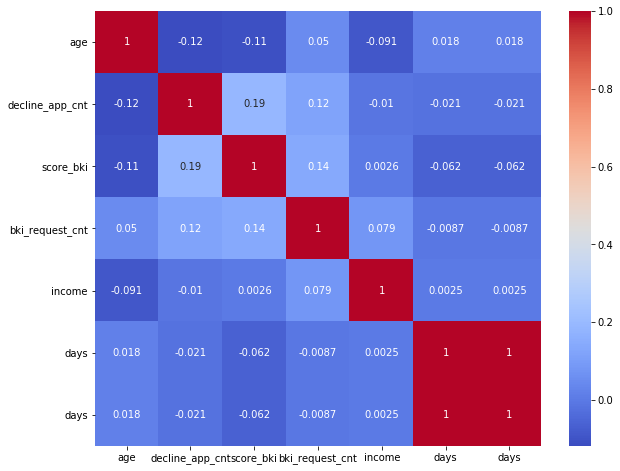

In [37]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax = sns.heatmap(df.loc[:,num_cols].corr(),annot = True, cmap = 'coolwarm')

сильно скорелированных между собой признаков нет, все берем в работу

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

In [38]:
tr_df['days'] = df[df.Train==1]['days']

C:\Users\Nikita Sergeevich\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


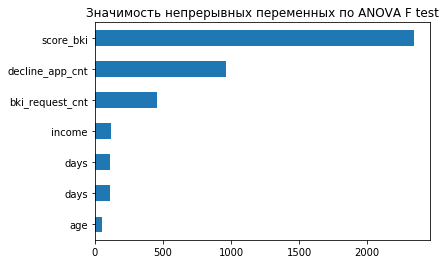

In [39]:
imp_num = pd.Series(f_classif(tr_df[num_cols], tr_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

Посмотрим на значимость категориальных и бинарных переменных

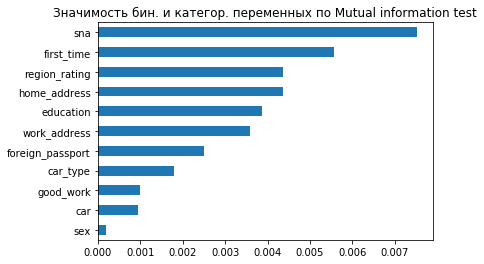

In [40]:
cat_and_bin_cols = cat_cols+bin_cols
tr_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(tr_df[cat_and_bin_cols], tr_df['default'], discrete_features =True), index = cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

Наиболее значимы связь заемщика с клиентами банка(sna) и давность наличия информации о заемщике(first_time). Наименее значим пол(sex).

# 3. Подготовка данных к машинному обучению

In [41]:
# реализуем метод OneHotLabels через get_dummies
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [42]:
# стандартизиуем числовые признаки
data_num = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = num_cols)

In [43]:
df[num_cols] = data_num

In [44]:
df.head(2)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,month,days,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,1.714029,1,1,-0.341893,0,-0.208688,-0.281790,-0.786080,0,0.0,1,2,-0.934391,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,1.542867,0,0,-0.341893,0,0.745419,0.770563,-0.708472,0,0.0,1,3,0.281474,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0


In [45]:
#удалим нечисловой признак
df.drop(['app_date'], axis=1, inplace=True)

# 4. Построение модели

In [46]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # таргет
X = train_data.drop(['default'], axis=1)

In [47]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Создадим класс с разныи метриками для оценки модели

In [48]:
class ModelInspect():  
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure(figsize=(8,8))
        plt.plot([0, 1], label='Random', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Pastel1', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
    
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)
        
        plt.show()

In [49]:
# первая модель на автомате
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

C:\Users\Nikita Sergeevich\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
mi_1 = ModelInspect(model, X_test, y_test)

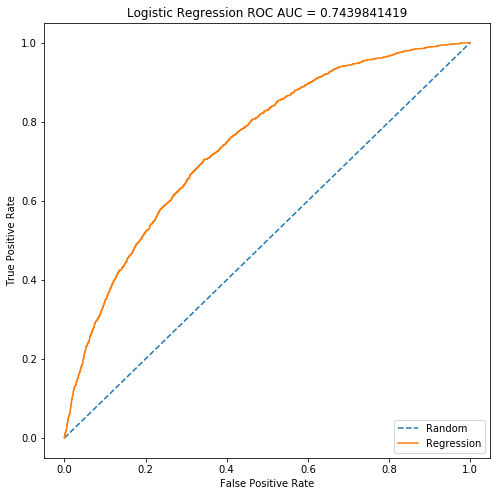

In [51]:
mi_1.roc_curve_plot()

Получилась достаточно большая величина ROC AUC. Посмотрим на остальные метрики.

In [52]:
mi_1.get_metrics()

accuracy     0.874390
precision    0.363636
recall       0.019704
F1           0.037383
ROC_AUC      0.743984
dtype: float64

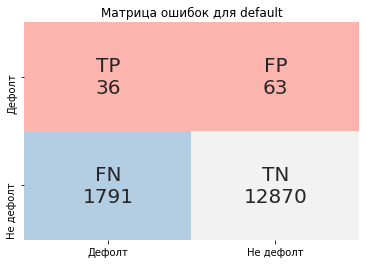

In [53]:
mi_1.confusion_matrix_plot()

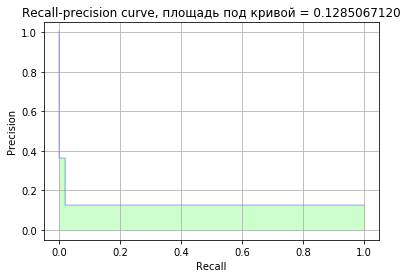

In [54]:
mi_1.recall_precision_plot()

Заключение по модели без регуляризации. Видны очень высокие значения ROC AUC и accuracy. Хорошее значение accuracy могло появиться из-за несбалансированности целевой переменной. Также видны низкие recall и f1. Модель часто ошибочно считает дефолт не дефолтом(много FN(опять же, причина может быть в том, что модель предпочитвает предсказывать более частовстречающийся класс)).

Для улучшения предсказательной силы модели попробуем сбалансировать модель и добавить регуляризацию

# 5. Улучшение модели

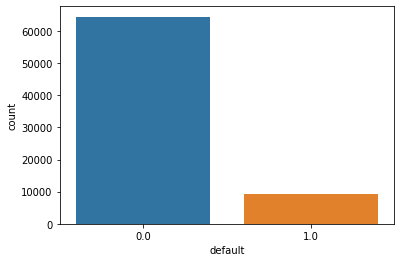

In [55]:
ax = sns.countplot(x="default", data=df)

выборка несбалансирована. Введем веса классов, прямо-пропорциональные количеству объектов каждого класса (потом их нужно ввести в оптимизационный функционал)

In [56]:
print('класс 0: ', len(y_train[y_train == 0]))
print('класс 1: ', len(y_train[y_train == 1]))
Y = train_data.default.values
print('веса классов: w0 = {0}, w1 = {1}'.format(round(len(Y[Y == 0])/len(Y[Y == 1])), 1))

класс 0:  51494
класс 1:  7545
веса классов: w0 = 7, w1 = 1


sklearn.linear_model.LogisticRegression уже умеет учитывать веса классов при оптимизации. Для этого есть параметр class_weight

In [57]:
model = LogisticRegression(class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_balanced = ModelInspect(model, X_test, y_test)

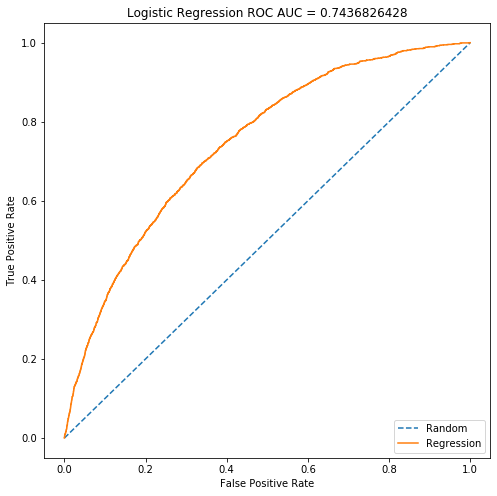

In [58]:
mi_balanced.roc_curve_plot()

In [59]:
mi_balanced.get_metrics()

accuracy     0.670325
precision    0.226068
recall       0.686371
F1           0.340114
ROC_AUC      0.743683
dtype: float64

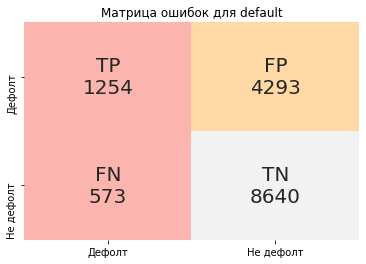

In [60]:
mi_balanced.confusion_matrix_plot()

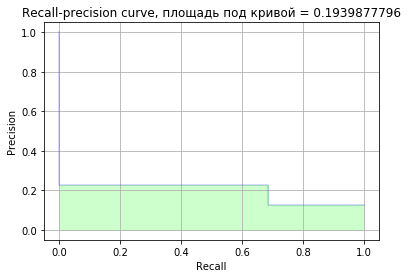

In [61]:
mi_balanced.recall_precision_plot()

Теперь recall и f1 сильно выросли, однако accuracy упало. Действительно, модель как бы подгонялась под наиболее частый класс и была склонна к тому, чтобы предсказывать его. С добавлением весов эта проблема ушла. Однако теперь модель чаще стала ошибочно предсказывать дефолт.

### Регуляризация

Проверим нулевые коэфиициенты 

In [62]:
model = LogisticRegression(random_state = RANDOM_SEED, 
                           C = 1, 
                           class_weight = 'balanced', 
                           penalty = 'l1', 
                           solver = 'liblinear',
                           )
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(38,1), model.coef_.reshape(38,1))), columns = ['col', 'coef'])

In [64]:
df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)

,col,coef,abs_coef
23,region_rating_80,-0.862521,0.862521
17,region_rating_20,0.593755,0.593755
12,education_0,-0.536327,0.536327
22,region_rating_70,-0.533117,0.533117
6,score_bki,0.491363,0.491363
18,region_rating_30,0.47894,0.47894
15,education_3,0.383713,0.383713
27,work_address_1,-0.312733,0.312733
30,sna_1,-0.291241,0.291241
14,education_2,-0.289657,0.289657


In [65]:
list(np.array(df_coef[df_coef.coef == 0].col))

['region_rating_50', 'sna_2', 'first_time_1']

Нулевые коэффициенты означают, что признаки не очень важны для модели, их вполне можно отбросить

In [66]:
cols_4del = list(np.array(df_coef[df_coef.coef == 0].col))
cols_4del

['region_rating_50', 'sna_2', 'first_time_1']

In [67]:
X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

C:\Users\Nikita Sergeevich\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Смотрим теперь на модель

In [68]:
model = LogisticRegression(max_iter = 2000, class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_drop0coef = ModelInspect(model, X_test, y_test)

In [69]:
pd.concat([mi_balanced.get_metrics(),mi_drop0coef.get_metrics()], axis = 1)

,0,1
accuracy,0.670325,0.670325
precision,0.226068,0.226068
recall,0.686371,0.686371
F1,0.340114,0.340114
ROC_AUC,0.743683,0.743685


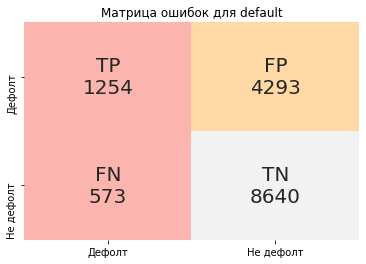

In [70]:
mi_drop0coef.confusion_matrix_plot()

Предсказания модели после удаления нулевых признаков не изменились

###  Подбор параметров

Искать будем с помощью  GridSearch

In [71]:
np.logspace(-1, 3, 10)

array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03])

In [72]:
C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3

In [73]:
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [74]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель, гиперпараметры
model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [ ]:
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

In [ ]:
mi_bestparams = ModelInspect(model_best_params, X_test, y_test)

In [ ]:
mi_bestparams.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_drop0coef.get_metrics(), mi_bestparams.get_metrics()],axis = 1)
metrics.columns = ['previous md', 'best params']
metrics

In [ ]:
mi_bestparams.confusion_matrix_plot()

In [ ]:
mi_drop0coef.confusion_matrix_plot()

In [ ]:
mi_bestparams.recall_precision_plot()

Подбор параметров с помощью GridSearchCV не дал практически никаких изменений для метрик модели

### Кросс-валидация

In [ ]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # таргет
X = train_data.drop(['default'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)
X.drop(cols_4del, axis = 1, inplace = True)

Создадим две модели: самую начальную, с дефольными параметрами, и с подобранными параметрами, и посмотрим на их метрики после 10-fold разбиения

In [ ]:
model_0 = LogisticRegression(random_state=RANDOM_SEED)
model_1 = LogisticRegression(C = 16.68100537200059,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 1000,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False)

In [ ]:
# испортируем библиотеку для kfold кросс-валидации 
from sklearn.model_selection import cross_val_score

In [ ]:
scores_0 = cross_val_score(model_0, X, y, cv=10, scoring='f1')
scores_1 = cross_val_score(model_1, X, y, cv=10, scoring='f1')

In [ ]:
x = np.arange(1,11)

fig, axes = plt.subplots(figsize=(10,5))
plt.plot(x, scores_0, label = 'дефолтный режим', linewidth=10)
plt.plot(x, scores_1, label = 'подобранные параметры', linewidth=10)
plt.title('Кросс-валидация для моделей с разной регуляризацией')
plt.ylabel('значение F1')
plt.xlabel('номер фолда')
ax.set_xticks(x)
yticks = np.arange(0.32, 0.36, 0.002)
plt.legend(loc = 'center')
ax.set_yticks(yticks)
ax.grid(True)


Последняя модель стабильно дает лучшие результаты, чем дефолтная(это так, просто иллюстрация)

In [ ]:
x = np.arange(1,11)

fig, axes = plt.subplots(figsize=(10,5))
plt.plot(x, scores_1, label = 'подобранные параметры', linewidth=10)
plt.title('Кросс-валидация')
plt.ylabel('значение F1')
plt.xlabel('номер фолда')
ax.set_xticks(x)
yticks = np.arange(0.32, 0.36, 0.002)
plt.legend(loc = 'lower left')
ax.set_yticks(yticks)
ax.grid(True)

Итак, оставляем последнюю модель с наилучшими параметрами

# 6. Вывод
1. Заметные изменения по сравнению с дефолтным набором признаков принесло добавление весов в выборку. 
Изначальный ее дисбаланс приводил к большой ошибке FN и, как следствие, маленьким значениям recall. Добавление же весов избавило от этой проблемы, однако, снизило значение precision. Наверное, лучшие иметь неплохими все метрики, чем одни очень хорошими, а другие очень плохими(мне так кажется, возможно, это неправда).
2.  Подбор оптимальных параметров с помощью GridSearchCV же не принес видимого результата.
Кажется, что нет особой разници, пользоваться ли моделью с дефолтными параметрами и весами, или с подобранными параметрами и весами. Для submission выбрана модель с подобранными параметрами.
3. Все изменения параметров модели практически не влияли на значение ROC AUC.


## Submission

In [ ]:
model_best_params

In [ ]:
test_data = df.query('Train == 0').drop(['Train'], axis=1)
test_data.drop(cols_4del, axis = 1, inplace = True)
X_test = test_data.drop(['default', 'client_id'], axis=1)

In [ ]:
y_pred_prob = model_best_params.predict_proba(X_test)[:,1]

In [ ]:
submit = pd.DataFrame(test_data.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)